In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import zconfint
%matplotlib inline

# Загрузка данных

In [13]:
studs = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', delimiter=';')
groups = pd.read_csv('groups.csv', delimiter=';')

In [14]:
studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [15]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
groups.head()

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B


# Выбор метрик

Исходя из того, что нам известна информация только об олпатах пользователей, разумно посчитать следующие метрики: ARPU, ARPPU, CR в покупку и средний чек.
Также может быть полезна доля активных пользователей.

# Подготовка данных

 Удалим пользователей, не зашедших во время проведения A/B теста.

In [17]:
payed_users = checks.merge(studs, how='inner', on='student_id')
data_ab = pd.merge(payed_users, groups, left_on='student_id', right_on='id')

Считаем средний чек

In [45]:
data_ab.groupby(['grp'])['rev'].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


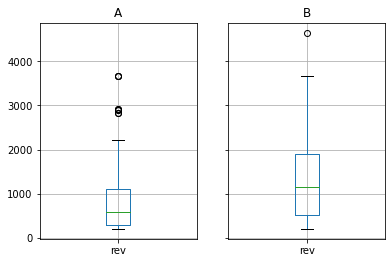

In [73]:
data_ab[['rev', 'grp']].groupby('grp').boxplot();

Нарисуем гистограммы выручки

In [18]:
users_A = data_ab[data_ab['grp'] == 'A'].rev
users_B = data_ab[data_ab['grp'] == 'B'].rev

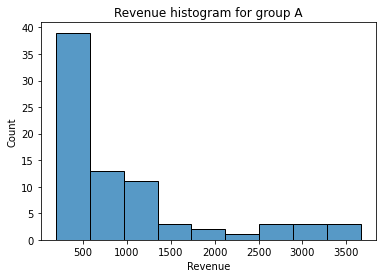

In [104]:
sns.histplot(users_A)
plt.title('Revenue histogram for group A');
plt.xlabel('Revenue');

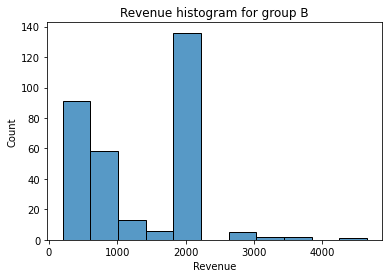

In [105]:
sns.histplot(users_B)
plt.title('Revenue histogram for group B');
plt.xlabel('Revenue');

Как и ожидалось, распределение сильно скошено, используем непараметрический критерий для проверки гипотезы.

# Проверим нулевую гипотезу о равенстве средних чеков против двусторонней альтернативы

Посчитаем 95%-тный доверительный интервал для среднего чека:

In [94]:
print('95%-th confidence interval for the mean (A): {0}'.format(zconfint(users_A)))

95%-th confidence interval for the mean (A): (729.436233384177, 1137.74325379531)


In [95]:
print('95%-th confidence interval for the mean (B): {0}'.format(zconfint(users_B)))

95%-th confidence interval for the mean (B): (1170.4037378048192, 1345.3542462716136)


Видим, что доверительные интервалы не пересекаются.

In [97]:
stats.mannwhitneyu(users_A, users_B)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0001255696915703461)

Получаем, что Pvalue << 0.05 и отвергаем нулевую гипотезу.

# Подсчет метрик

Посчитаем ARPU

In [12]:
pd.merge(studs, groups, left_on='student_id', right_on='id').groupby('grp').size()

grp
A    1538
B    6803
dtype: int64

In [30]:
arpu_a = users_A.sum()/1538.
arpu_b = users_B.sum()/6803.

In [27]:
print("ARPU for group A is equal to {}".format(arpu_a))
print("ARPU for group B is equal to {}".format(arpu_b))

ARPU for group A is equal to 47.34720416124838
ARPU for group B is equal to 58.05879810377775


Считаем ARPPU

In [31]:
arppu_a = users_A.sum()/len(users_A)
arppu_b = users_B.sum()/len(users_B)

In [32]:
print("ARPPU for group A is equal to {}".format(arppu_a))
print("ARPPU for group B is equal to {}".format(arppu_b))

ARPPU for group A is equal to 933.5897435897435
ARPPU for group B is equal to 1257.8789920382164


Считаем CR в покупку

In [34]:
pd.merge(studs, groups, left_on='student_id', right_on='id').groupby('grp').size()

grp
A    1538
B    6803
dtype: int64

In [36]:
CR_a = len(users_A)/1538.
CR_b = len(users_B)/6803.

In [37]:
print("CR for group A is equal to {}".format(CR_a))
print("CR for group B is equal to {}".format(CR_b))

CR for group A is equal to 0.05071521456436931
CR for group B is equal to 0.046156107599588415


# Вывод

Таким образом, статистически значимо растут все метрики кроме CR, и скорее всего стоит запустить новую механику оплаты.